# Conjugate Gradient Descent

In [3]:
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import autograd.numpy as np
from autograd import grad, jacobian, hessian

import plot as p
import cg
import matplotlib.pyplot as plt

from rosenbrock import rosenbrock

assert "autograd" in np.__file__ # Need to make sure that we get the correct numpy - my config/other imports might import the default one.

# Linear CG

## 2d Example

Remember that CG is used to solve a linear function,

$$
Ax = b
$$

by instead minimizing,

$$
f(x) = \frac{1}{2} x^T A x - b^T x
$$

In [3]:
A = np.array([
    [1, 0],
    [0, 3],
])
b = np.array([
    [0],
    [0],
])

def _reshape_grid(x):
    return x.T[:,:,np.newaxis]
    
# x needs to be a list of column vectors
def f(x):
    if len(x.shape) == 2 and x.shape[0] == 2:
        x = _reshape_grid(x)
    
    assert len(x.shape) == 3
    dims = A.shape[0]
    assert x.shape[1:] == (dims, 1)
    xr = x
    xl = x.transpose((0, 2, 1))
    return (0.5 * np.matmul(xl, np.matmul(A, xr)) - np.matmul(b.T, xr)).flatten()

In [4]:
x0 = np.array([1, 0.3])
positions = cg.conjugate_gradient(A, b.flatten(), x0)

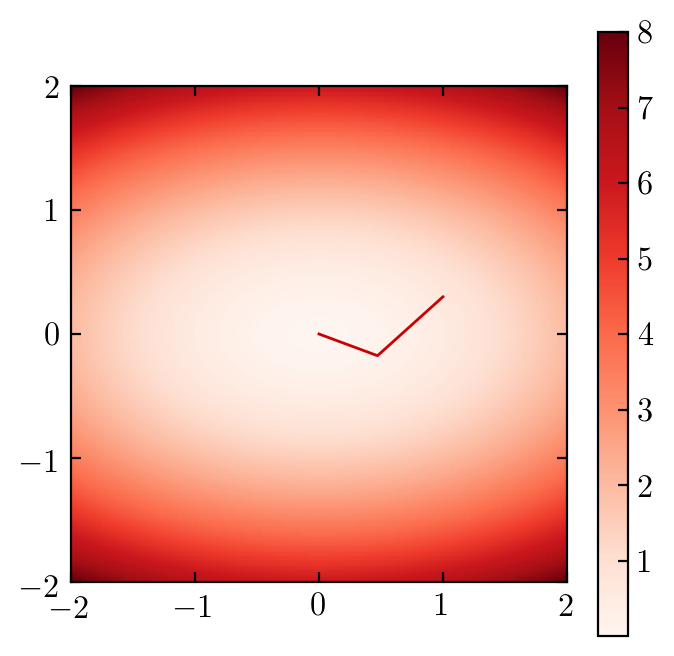

In [5]:
ax = p.plot_func(f, typ="image")
ax.plot(positions[:,0], positions[:,1])

## Large Example

Above we showed visually how CG works in a simple 2d problem. Now lets see how it performs in a large problem.

The first problem is to construct a large PSD $A$ matrix.

In [52]:
def construct_Ab_inputs(dims, eigenvalues):
    
    r = np.random.random((dims, dims))
    q, _ = np.linalg.qr(r)
    
    assert np.isclose(np.dot(q[:,0], q[:,1]), 0) # columns are orthogonal

    A = np.matmul(q.T, np.matmul(np.diag(eigenvalues), q))
    b = np.random.uniform(1, 10, size=dims)    
    return A, b

1001
259


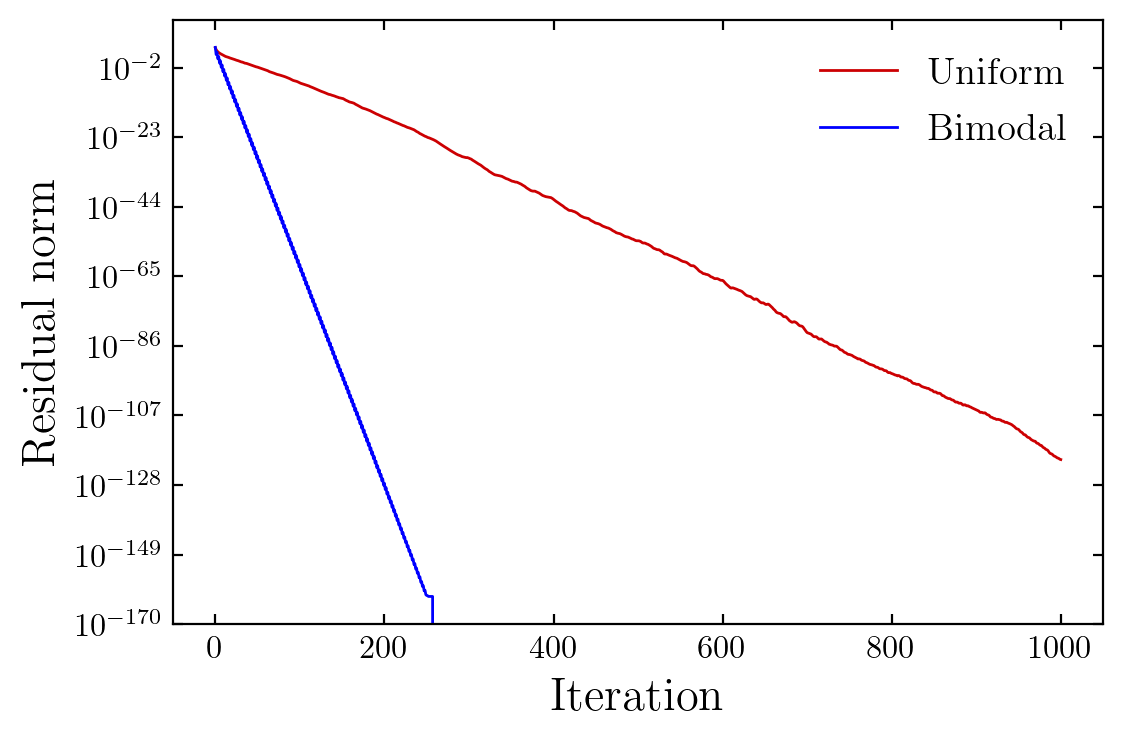

In [55]:
dims = int(1e3)
_, ax = plt.subplots()

for (ev, label) in [
    (np.random.uniform(10, 1000, size=dims), "Uniform"),
    (np.concatenate((np.random.uniform(9, 11, size=dims//2), np.random.uniform(999, 1001, size=dims//2))), "Bimodal"),
]:
    A, b = construct_Ab_inputs(dims, ev)
    x0 = np.random.random(dims)

    positions, residual_norm = cg.conjugate_gradient(A, b, x0)
    print(len(positions))

    assert np.allclose(np.matmul(A, positions[-1]), b)
    ax.plot(residual_norm, label=label)
ax.set(yscale="log", ylabel="Residual norm", xlabel="Iteration")
ax.legend()

# Nonlinear CG

## 2d Rosenbrock

Solved in 68 steps


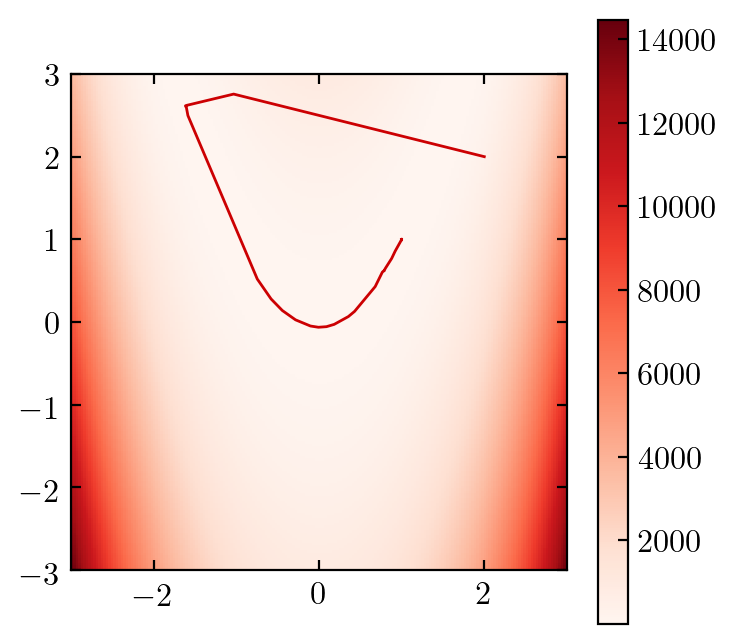

In [37]:
ax = p.plot_func(rosenbrock, typ="image", lim=[-3, 3, -3, 3])

x0 = np.array([2., 2.])
pos = cg.fletcher_reeves(rosenbrock, grad(rosenbrock), x0)

ax.plot(pos[:,0], pos[:,1])
print(f"Solved in {len(pos)} steps")

## Large example

In [48]:
dims = 10
x0 = np.random.normal(size=dims)
def log_results(pos):   
    print(f"Final position is {pos[-1]} which is close to the known optimum: {np.allclose(pos[-1], 1)}")
    print(f"This took {len(pos)} steps") 

In [49]:
# Straight FR
pos = cg.fletcher_reeves(rosenbrock, grad(rosenbrock), x0, use_pr=False, restart=None)
log_results(pos)

Final position is [1.         1.         1.         1.         1.         1.         1.         1.         1.         0.99999999] which is close to the known optimum: True
This took 88935 steps


In [50]:
# FR with restarts
pos = cg.fletcher_reeves(rosenbrock, grad(rosenbrock), x0, use_pr=False, restart=0.1)
log_results(pos)

Final position is [1.         1.         1.         1.         1.         0.99999999 0.99999999 0.99999997 0.99999994 0.99999989] which is close to the known optimum: True
This took 424 steps


In [51]:
# PR
pos = cg.fletcher_reeves(rosenbrock, grad(rosenbrock), x0, use_pr=True, restart=None)
log_results(pos)

Final position is [1.         1.         1.         1.         1.         1.         1.         1.00000001 1.00000001 1.00000002] which is close to the known optimum: True
This took 415 steps
